# **<center> Credit risk model - HMEQ data </center>**

<center><span style="font-size:24px;"><b>Section 1:</b> Preprocessing and EDA</span></center>

## Introduction to this section

The HMEQ dataset reports information about 5960 home equity loans. This is a loan where the borrower uses the equity of their home as collateral.

The dataset has the following features [original name]:

- `DEFAULT [BAD]`: '1' = Applicant defaulted on loan or seriously delinquent; '0' = Applicant paid loan.
- `OUTSTANDING MORTGAGE [MORTDUE]`: Amount due on existing mortgage.
- `PROPERTY VALUE [VALUE]`: Value of current property.
- `JOB`: Occupational categories.
- `YEARS AT JOB [YOJ]`: Years at present job.
- `DEROGATORY REPORTS [DEROG]`: Number of major derogatory reports.
- `DELINQUENT CREDIT LINES [DELINQ]`: Number of delinquent credit lines.
- `OLDEST CREDIT (MONTHS) [CLAGE]`: Age of oldest credit line in months.
- `RECENT CREDIT ENQUIRIES [NINQ]`: Number of recent credit enquiries.
- `CREDIT LINES [CLNO]`: Number of credit lines.
- `DEBTINC`: Debt-to-income ratio.

I aim to calculate the RWA (risk-weighted assets) and capital requirements for the bank's portfolio in accordance with Basel III, using both the standardised approach (SA) and internal ratings-based approach (IRB). The IRB approach requires a model that predicts each borrower's probability of default (PD), which will then be incorporated into the final calculation. 

In this section, I split the data into training, validation and test sets, and explore the training data. I use a validation set to determine whether the performance on my training set transfers across to the validation set. If so, I can proceed confidently to the test set; if not, I still have the chance to make changes to my model before applying it to the test set.

I explore the training data using histograms to determine the distribution of each variable and easily identify any anomalies. These anomalies are then transformed where appropriate. After transforming anomalies, I determine which variables (features) can easily be discarded using a combination of VIF (to check for multicollinearity between variables) and single feature selection (to determine which variables have very limited predictive power). If I am able to discard variables at this stage, it will be easier to build a more complex model in the next section.

After I apply the feature de-selection methods to my training data, I export the data so that the remaining variables can be used for more complex feature selection in the next section. In the first two sections, I build the PD model. In the final section, I calculate RWA and capital requirements based on the Basel III regulations.

## Imports

In [1]:
from IPython.core.display import HTML

with open("../styles/styles.css", "r") as file:
    css = file.read()
display(HTML(f"<style>{css}</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import sys
import os


sys.path.append(os.path.abspath(".."))
import random

from functions import (
    training_val_test_split,
    calculate_target_percentage,
    data_quality_check,
    convert_object_to_category,
    duplicate_check,
    missing_values_by_row,
    correlation_matrix,
    describe_dataframe,
    chart_visualisations,
    calculate_bins_for_eda,  # used in the chart_visualisations function
    transform_anomalies,
    calculate_single_predictor_metrics,
    drop_irrelevant_columns,
    check_vif,
    show_defaults_in_missing_values,
    create_boxplots,
)

In [2]:
# load the dataset
df = pd.read_csv("../datasets/mortgage_default - hmeq.csv")

df.index = range(len(df))
df.index.name = "idx"

df.head()

# note to self: consider converting this to an API so that users don't need the same file path.

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
idx,,,,,,,,,,,
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
df.rename(
    columns={
        "BAD": "DEFAULT",
        "MORTDUE": "OUTSTANDING MORTGAGE",
        "VALUE": "PROPERTY VALUE",
        "YOJ": "YEARS AT JOB",
        "DEROG": "DEROGATORY REPORTS",
        "DELINQ": "DELINQUENT CREDIT LINES",
        "CLAGE": "OLDEST CREDIT (MONTHS)",
        "NINQ": "RECENT CREDIT ENQUIRIES",
        "CLNO": "CREDIT LINES",
    },
    inplace=True,
)

## Data quality check

Debt-to-income ratio (DEBTINC) has a very high number of missing values. This could be a problem if the data is missing completely at random (MCAR). However, it may be that there is a reason for a missing DEBTINC ratio. Similarly, the number of derogatory reports and delinquent credit lines is on the limit of an acceptable coverage ratio (1 - missing values %). These will be investigated later.

In [4]:
data_quality_check(df)  # imported from data_quality_test_functions.py

,Column,Data Type,Non-Null Count,Missing Values,% Missing Values,Unique Values,Anomaly Check
10,DEBTINC,float64,4693,1267,21.258389,4693,No anomalies detected
5,DEROGATORY REPORTS,float64,5252,708,11.879195,11,No anomalies detected
6,DELINQUENT CREDIT LINES,float64,5380,580,9.731544,14,No anomalies detected
1,OUTSTANDING MORTGAGE,float64,5442,518,8.691275,5053,No anomalies detected
4,YEARS AT JOB,float64,5445,515,8.640940,99,No anomalies detected
8,RECENT CREDIT ENQUIRIES,float64,5450,510,8.557047,16,No anomalies detected
7,OLDEST CREDIT (MONTHS),float64,5652,308,5.167785,5314,No anomalies detected
3,JOB,object,5681,279,4.681208,6,Contains non-string values
9,CREDIT LINES,float64,5738,222,3.724832,62,No anomalies detected
2,PROPERTY VALUE,float64,5848,112,1.879195,5381,No anomalies detected


The anomaly in the JOB column is because it contains missing values. NaN is not a string value (hence the anomaly in the JOB column) but is a float value (hence no anomalies in other columns).

***Note to self:*** *The Anomaly Check column should be redesigned, because if a column has any anomalies, it will be converted to an object datatype (ie. if a float column contains a single string value, it will cease to be a float column, and therefore no anomalies will be detected).*

In [5]:
df["JOB"].unique()

array(['Other', nan, 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'],
      dtype=object)

In [6]:
# not strictly necessary, but to save memory
convert_object_to_category(df)  # imported from optimisation_functions.py

Converted column 'JOB' from 'object' to 'category'


#### Addition of LTV ratio column

`LTV RATIO`: The ratio of a borrower's outstanding mortgage to the value of their collateral.

To detect outliers, I add a loan-to-value (LTV) column. It is unlikely that a bank would offer a mortgage equal in value to the value of the property, but it is possible that a home loses value after a loan is made, so that should be accounted for. LTV ratios much higher than one, however, are likely to be unrealistic.  

In [7]:
df["LTV RATIO"] = df["OUTSTANDING MORTGAGE"] / df["PROPERTY VALUE"]

The average LTV ratio is considerably higher than the suggested 0.45 to be imputed if Outstanding Mortgage is missing.

In [ ]:
df["LTV RATIO"].mean()

0.7084935888122207

In [9]:
describe_dataframe(df)  # imported from eda_functions.py

,count,mean,std,min,25%,50%,75%,max
DEFAULT,5960.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
OUTSTANDING MORTGAGE,5442.0,73760.82,44457.61,2063.00,46276.00,65019.00,91488.00,399550.00
PROPERTY VALUE,5848.0,101776.05,57385.78,8000.00,66075.50,89235.50,119824.25,855909.00
YEARS AT JOB,5445.0,8.92,7.57,0.00,3.00,7.00,13.00,41.00
DEROGATORY REPORTS,5252.0,0.25,0.85,0.00,0.00,0.00,0.00,10.00
DELINQUENT CREDIT LINES,5380.0,0.45,1.13,0.00,0.00,0.00,0.00,15.00
OLDEST CREDIT (MONTHS),5652.0,179.77,85.81,0.00,115.12,173.47,231.56,1168.23
RECENT CREDIT ENQUIRIES,5450.0,1.19,1.73,0.00,0.00,1.00,2.00,17.00
CREDIT LINES,5738.0,21.30,10.14,0.00,15.00,20.00,26.00,71.00
DEBTINC,4693.0,33.78,8.60,0.52,29.14,34.82,39.00,203.31


As mentioned earlier, missing collateral values should be imputed assuming an LTV ratio of 0.45. This seems to be far 'safer' than our dataset suggests. The 25th percentile of values is at 0.62, suggesting that we have a lot of risky loans. (I believe this would create an incentive to delete at least 75% of values in the property value column and impute them with the suggested LTV ratio, so I will ignore this recommendation.)

## Dataset split

I split the dataset into training, validation and test data.

In [10]:
training_df, validation_df, test_df = training_val_test_split(df, stratify=["DEFAULT"])

# imported from split_functions.py

Datasets created:
 - Training set: 3874 rows
 - Validation set: 596 rows
 - Test set: 1490 rows




In [11]:
datasets = [
    ("training_df", training_df),
    ("validation_df", validation_df),
    ("test_df", test_df),
]

calculate_target_percentage(datasets, "DEFAULT")  # imported from split_functions.py

Percentage of 1s in target column:
 - training_df: 19.95%
 - validation_df: 19.97%
 - test_df: 19.93%


This seems like a high default rate. It doesn't mean that there is a problem with the dataset, but may mean that balancing the training data is less necessary. 

## Training data

### Exploratory data analysis

The missing values in the training data are broadly similar to those from the overall dataset.

In [12]:
data_quality_check(training_df)  # imported from data_quality_test_functions.py

,Column,Data Type,Non-Null Count,Missing Values,% Missing Values,Unique Values,Anomaly Check
10,DEBTINC,float64,3039,835,21.553949,3039,No anomalies detected
5,DEROGATORY REPORTS,float64,3415,459,11.848219,11,No anomalies detected
11,LTV RATIO,float64,3492,382,9.860609,3476,No anomalies detected
6,DELINQUENT CREDIT LINES,float64,3501,373,9.628291,13,No anomalies detected
1,OUTSTANDING MORTGAGE,float64,3543,331,8.544140,3343,No anomalies detected
4,YEARS AT JOB,float64,3552,322,8.311822,85,No anomalies detected
8,RECENT CREDIT ENQUIRIES,float64,3552,322,8.311822,14,No anomalies detected
7,OLDEST CREDIT (MONTHS),float64,3668,206,5.317501,3494,No anomalies detected
3,JOB,category,3693,181,4.672173,6,No anomalies detected
9,CREDIT LINES,float64,3729,145,3.742901,62,No anomalies detected


Missing property value data seems to be very highly correlated with defaults, as does missing debt-to-income ratio data. This missing data therefore should not be deleted. On the opposite end, rows with missing delinquent credit lines and derogatory reports have a lower than average rate of default. This may suggest that missing values represent no delinquent credit lines or derogatory reports.

In summary, some columns with missing values have too much information to be deleted.

In [13]:
show_defaults_in_missing_values(training_df)  # imported from eda_functions.py

,Column Name,Percentage of Defaults,Number of Missing Values,Percentage of Defaults in Missing
1,PROPERTY VALUE,19.95,67,92.54
9,DEBTINC,19.95,835,61.20
10,LTV RATIO,19.95,382,29.84
6,OLDEST CREDIT (MONTHS),19.95,206,26.21
8,CREDIT LINES,19.95,145,23.45
0,OUTSTANDING MORTGAGE,19.95,331,19.03
7,RECENT CREDIT ENQUIRIES,19.95,322,14.60
3,YEARS AT JOB,19.95,322,13.04
5,DELINQUENT CREDIT LINES,19.95,373,12.33
4,DEROGATORY REPORTS,19.95,459,12.20


Consider how to deal with rows that have multiple values missing.

In [14]:
missing_values_by_row(training_df)  # imported from data_quality_test_functions.py

,count
missing_values_per_row,
0,2220
1,919
2,296
3,192
4,54
5,44
6,62
7,29
8,12


Only two 'duplicates' are found in the training data. In reality, there are so many missing values that it is unclear whether this represents the same borrower or two separate borrowers. These can be left; they will be automatically transformed later.

In [15]:
duplicate_check(training_df)  # imported from data_quality_test_functions.py

Found 2 duplicate rows.


,DEFAULT,OUTSTANDING MORTGAGE,PROPERTY VALUE,JOB,YEARS AT JOB,DEROGATORY REPORTS,DELINQUENT CREDIT LINES,OLDEST CREDIT (MONTHS),RECENT CREDIT ENQUIRIES,CREDIT LINES,DEBTINC,LTV RATIO
idx,,,,,,,,,,,,
1144,1,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1553,1,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# set include='all' to show non-numeric columns (ie. 'JOB')
describe_dataframe(training_df)  # imported from eda_functions.py

,count,mean,std,min,25%,50%,75%,max
DEFAULT,3874.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
OUTSTANDING MORTGAGE,3543.0,73737.49,44260.81,2063.00,46124.50,65178.00,91731.50,399550.00
PROPERTY VALUE,3807.0,101887.66,56405.46,8000.00,66086.50,89640.00,120043.50,855909.00
YEARS AT JOB,3552.0,8.92,7.63,0.00,3.00,7.00,13.00,41.00
DEROGATORY REPORTS,3415.0,0.26,0.86,0.00,0.00,0.00,0.00,10.00
DELINQUENT CREDIT LINES,3501.0,0.45,1.13,0.00,0.00,0.00,0.00,13.00
OLDEST CREDIT (MONTHS),3668.0,179.82,87.29,0.00,115.56,173.60,230.25,1168.23
RECENT CREDIT ENQUIRIES,3552.0,1.18,1.73,0.00,0.00,1.00,2.00,13.00
CREDIT LINES,3729.0,21.16,10.16,0.00,14.00,20.00,26.00,71.00
DEBTINC,3039.0,33.81,8.25,0.52,29.16,34.88,39.01,203.31


The debt-to-income ratio seems high. I will keep this for now, as it might be useful, but I'm prepared to drop it if the column performs below average in the feature selection process.

As mentioned previously, the LTV ratio also seems very high. Why is the suggested LTV ratio for missing values 0.45, when the median is so high here? Does this not just create an incentive for companies to delete any values above 0.45?

The most common response in the job column is 'Other'. These will be replaced with NaN, because it is unclear whether 'Other' discriminates between those with no job and those with jobs that don't fall into the other categories. I will consider dropping this column later if it's not a good predictor of default rate; the values are ambiguous and many of the rows have missing values.

In [17]:
training_df["JOB"] = training_df["JOB"].astype(str).replace("Other", np.nan)
training_df["JOB"] = training_df["JOB"].replace("nan", np.nan)

training_df["JOB"].unique()

array(['Mgr', 'ProfExe', nan, 'Sales', 'Office', 'Self'], dtype=object)

I then convert the job column to categorical data to save space.

In [18]:
convert_object_to_category(training_df)  # imported from optimisation_functions.py

Converted column 'JOB' from 'object' to 'category'


In [19]:
training_df.dtypes

DEFAULT                       int64
OUTSTANDING MORTGAGE        float64
PROPERTY VALUE              float64
JOB                        category
YEARS AT JOB                float64
DEROGATORY REPORTS          float64
DELINQUENT CREDIT LINES     float64
OLDEST CREDIT (MONTHS)      float64
RECENT CREDIT ENQUIRIES     float64
CREDIT LINES                float64
DEBTINC                     float64
LTV RATIO                   float64
dtype: object

#### Visualisations

I divide columns into their types to allow me to produce the appropriate chart for visualisation.

In [20]:
column_types = {
    "Continuous": [
        "PROPERTY VALUE",
        "OUTSTANDING MORTGAGE",
        "YEARS AT JOB",
        "OLDEST CREDIT (MONTHS)",
        "DEBTINC",
        "LTV RATIO",
    ],
    "Discrete": [
        "DEROGATORY REPORTS",
        "DELINQUENT CREDIT LINES",
        "RECENT CREDIT ENQUIRIES",
        "CREDIT LINES",
    ],
    "Category": ["JOB"],
}

The visualisations below shows a stacked count (left) and stacked percentage (right) of defaults (1) and non-defaults (0) for each feature. The visualisations on the right-hand side are a good rule of thumb for the likely discriminatory power a feature has, while the visualisations on the left show the number of features in each bin. A bin dominated by defaulters may appear very useful, but if the count of values in that bin is negligible, it will not have a significant impact on the overall power of the model.  

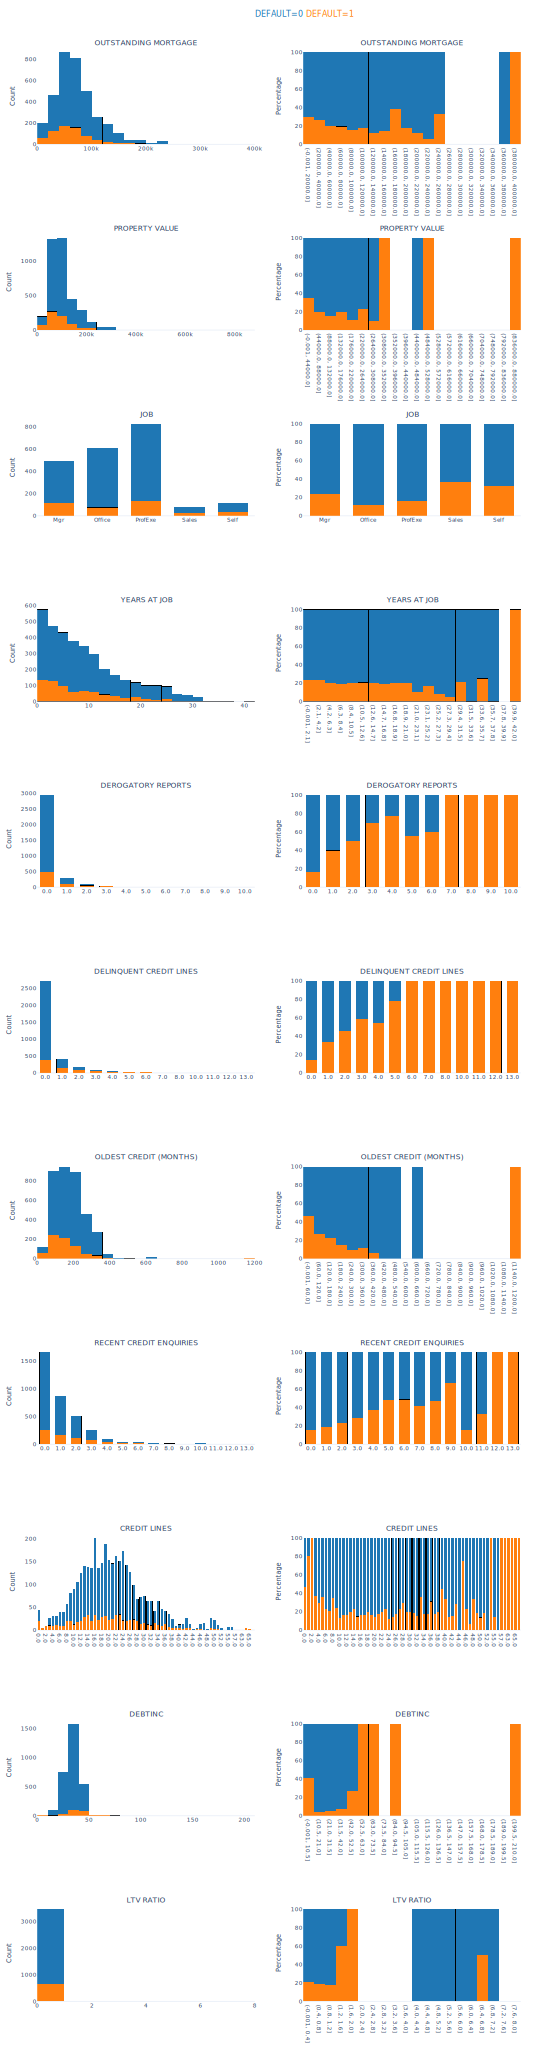

In [21]:
fig = chart_visualisations(
    training_df, columns_by_type=column_types
)  # imported from eda_functions.py

fig.show(
    "svg"
)  # figure loses functionality in GitHub, so open in Jupyter Notebook to see the absolute values for each bin

I also create boxplots for each column, but these are less useful than the visualisations above.

In [22]:
# create_boxplots(
#     training_df, columns_by_type=column_types
# )  # imported from eda_functions.py

#### Anomaly transformations

From the visualisations in the previous section, there are some suspiciously high LTV ratios. Realistically, no bank is going to give a loan higher than the value of the collateral. It may be that the value of the property falls, making the outstanding mortgage greater than the value of the property, but anything greater than 15% higher seems unrealistic.

In [23]:
training_df[training_df["LTV RATIO"] > 1.15]

# check to see whether these anomalies have a higher default rate than the average
# training_df[training_df["LTV RATIO"] > 1.15]["DEFAULT"].mean()

,DEFAULT,OUTSTANDING MORTGAGE,PROPERTY VALUE,JOB,YEARS AT JOB,DEROGATORY REPORTS,DELINQUENT CREDIT LINES,OLDEST CREDIT (MONTHS),RECENT CREDIT ENQUIRIES,CREDIT LINES,DEBTINC,LTV RATIO
idx,,,,,,,,,,,,
5443,0,235343.0,45270.0,Mgr,3.0,0.0,1.0,210.922403,3.0,49.0,41.264806,5.198653
2597,1,62100.0,40000.0,ProfExe,1.0,0.0,0.0,111.600000,2.0,13.0,NaN,1.552500
5550,0,239987.0,43028.0,Mgr,2.0,0.0,1.0,210.189005,3.0,49.0,41.336627,5.577461
5479,0,236847.0,46091.0,Mgr,1.0,0.0,2.0,205.650660,3.0,49.0,41.832674,5.138682
5557,0,238104.0,43026.0,Mgr,3.0,0.0,1.0,206.647079,3.0,49.0,41.276637,5.533956
5496,0,240157.0,42013.0,Mgr,3.0,0.0,2.0,201.612299,2.0,50.0,41.644794,5.716254
5548,0,239513.0,37076.0,Mgr,0.0,0.0,1.0,183.373452,2.0,49.0,40.779849,6.460055
5092,1,61118.0,35184.0,Sales,10.0,4.0,2.0,134.648904,7.0,23.0,45.255290,1.737096
4225,1,82000.0,12500.0,ProfExe,3.0,0.0,0.0,117.766667,6.0,23.0,NaN,6.560000


Similarly, there is borrower with a credit line open nearly 100 years (1154 months). This seems very unlikely.

In [24]:
# training_df.nlargest(5, "OLDEST CREDIT (MONTHS)")

I will transform these anomalies to set a limit of 1.15 for LTV ratios and 720 months (60 years) for credit lines.

In [25]:
transform_anomalies(training_df)  # imported from transform_all_datasets_functions.py

All LTV ratios above 1.15 have been set to -1, along with the associated property value. Outstanding mortgage have been left unchanged, because this will be required later for the calculation of RWA. Oldest credit above 720 months have been set to 720, rather than -1. I transformed other values to -1 to make it easy to group them together when I do binning later, but there is only one value above 720 months, so it seems unnecessary to give it a separate bin.

In [26]:
# confirm that transformation was successful

# training_df[training_df["LTV RATIO"] > 1.15]
# training_df[training_df["LTV RATIO"] < 0]
# training_df[training_df["OLDEST CREDIT (MONTHS)"] > 720]

The mean LTV ratio has fallen slightly as a result of the transformation, but is still high. (Note: I am now including -1 values in this calculation, so it is not a perfect estimation of the mean.)

In [27]:
training_df["LTV RATIO"].mean()

0.6702776330955715

### Feature (de)selection

The data has been cleaned, explored and transformed (where anomalies were present). In this section, I determine which features should be excluded from the credit risk model.

To do this, I first determine which features are strongly correlated with one another. I do this using a correlation matrix and VIF (variance inflation factor) analysis. Where two features have a strong correlation with one another, one should be removed to avoid multicollinearity.

I then run a single factor model for each feature to determine its predictive ability. Those with the lowest predictive ability will be removed. The model is built in a later section.

#### Correlation matrix

Unsurprisingly, property value and outstanding mortgage are strongly correlated. One of the features will need to be dropped to avoid multicollinearity. This will be decided later.

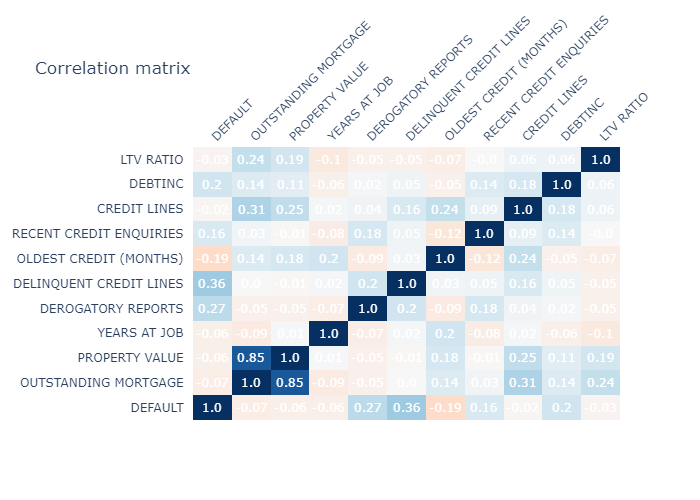

In [28]:
fig_2 = correlation_matrix(training_df)  # imported from eda_functions.py
fig_2.show("png")  # use only when uploading to GitHub, otherwise comment out

#### VIF score

A general rule-of-thumb is that a VIF (variance inflation factor) score of above 4 suggests a risk of multicollinearity (Pennsylvania State University, 2018).

In [29]:
check_vif(training_df)  # imported from feature_selection_functions.py

,VIF,feature
0,41.862557,const
1,3.574172,OUTSTANDING MORTGAGE
2,3.446724,PROPERTY VALUE
8,1.284565,CREDIT LINES
6,1.194152,OLDEST CREDIT (MONTHS)
4,1.161740,DEROGATORY REPORTS
10,1.159150,LTV RATIO
3,1.137820,YEARS AT JOB
7,1.116256,RECENT CREDIT ENQUIRIES
9,1.100544,DEBTINC


#### Single feature models

For each feature, I want to drop all null values before running a model (logistic regression does not allow null values). However, I don't want to delete all rows with null values, because I would be throwing away useful information for all columns in that row that aren't null.

I first take note of the number of non-null values for each feature.

In [30]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3874 entries, 89 to 4949
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DEFAULT                  3874 non-null   int64   
 1   OUTSTANDING MORTGAGE     3543 non-null   float64 
 2   PROPERTY VALUE           3807 non-null   float64 
 3   JOB                      2128 non-null   category
 4   YEARS AT JOB             3552 non-null   float64 
 5   DEROGATORY REPORTS       3415 non-null   float64 
 6   DELINQUENT CREDIT LINES  3501 non-null   float64 
 7   OLDEST CREDIT (MONTHS)   3668 non-null   float64 
 8   RECENT CREDIT ENQUIRIES  3552 non-null   float64 
 9   CREDIT LINES             3729 non-null   float64 
 10  DEBTINC                  3039 non-null   float64 
 11  LTV RATIO                3492 non-null   float64 
dtypes: category(1), float64(10), int64(1)
memory usage: 496.2 KB


I then encode `JOB` to allow for feature selection.

In [31]:
unique_jobs = training_df["JOB"].unique().dropna()
job_map = {job: i + 1 for i, job in enumerate(unique_jobs)}

training_df["JOB_encoded"] = training_df["JOB"].map(job_map)

comparison_df = pd.DataFrame(
    {"Original_JOB": training_df["JOB"], "Encoded_JOB": training_df["JOB_encoded"]}
)

print("\nUnique value mappings:")
comparison_df.drop_duplicates().set_index("Encoded_JOB").sort_values("Encoded_JOB")


Unique value mappings:


,Original_JOB
Encoded_JOB,
1,Mgr
4,Office
2,ProfExe
3,Sales
5,Self
NaN,NaN


I run a single factor model to identify and remove the least appropriate features (based on AUC and p-values). Other metrics, such as F1 score, accuracy, precision and recall, are used to determine the appropriate probability threshold on which to test the model.

In [32]:
# probability threshold set to 0.5 by default
calculate_single_predictor_metrics(
    training_df, "DEFAULT"
)  # imported from feature_selection_functions.py

Variable: OUTSTANDING MORTGAGE, Non-Null Values: 3543 (Feature), 3543 (Response)
Variable: PROPERTY VALUE, Non-Null Values: 3807 (Feature), 3807 (Response)
Variable: JOB, Non-Null Values: 2128 (Feature), 2128 (Response)
Error fitting model for variable 'JOB': Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Variable: YEARS AT JOB, Non-Null Values: 3552 (Feature), 3552 (Response)
Variable: DEROGATORY REPORTS, Non-Null Values: 3415 (Feature), 3415 (Response)
Variable: DELINQUENT CREDIT LINES, Non-Null Values: 3501 (Feature), 3501 (Response)
Variable: OLDEST CREDIT (MONTHS), Non-Null Values: 3668 (Feature), 3668 (Response)
Variable: RECENT CREDIT ENQUIRIES, Non-Null Values: 3552 (Feature), 3552 (Response)
Variable: CREDIT LINES, Non-Null Values: 3729 (Feature), 3729 (Response)
Variable: DEBTINC, Non-Null Values: 3039 (Feature), 3039 (Response)
Variable: LTV RATIO, Non-Null Values: 3492 (Feature), 3492 (Response)
Variable: JOB_encoded, Non-Null Values: 212

,Variable,Beta,Intercept,AUC,p-value
5,DELINQUENT CREDIT LINES,0.712273,-1.743214,0.672940,0.00
9,DEBTINC,0.095344,-5.775423,0.664224,0.00
6,OLDEST CREDIT (MONTHS),-0.006598,-0.315172,0.644562,0.00
4,DEROGATORY REPORTS,0.734773,-1.557037,0.617572,0.00
7,RECENT CREDIT ENQUIRIES,0.195448,-1.619312,0.595719,0.00
0,OUTSTANDING MORTGAGE,-0.000005,-1.050799,0.568521,0.00
1,PROPERTY VALUE,-0.000003,-1.188974,0.562956,0.00
3,YEARS AT JOB,-0.021090,-1.169807,0.542894,0.00
11,JOB_encoded,-0.080232,-1.278020,0.533595,0.07
8,CREDIT LINES,-0.004145,-1.310550,0.517404,0.31


`LTV RATIO` and `CREDIT LINES` have a p-value too high to be included in the model. They will be dropped. `JOB` will also be dropped because its predictive power is not high enough to overcome the large number of missing values.

`OUTSTANDING MORTGAGE` has very similar predictive power to `PROPERTY VALUE`, but it has more missing values and a considerably lower percentage of defaults in its missing values (which were not included in the single feature models). Both features are highly correlated and have a high VIF, so one must be removed.

I have decided to remove `OUTSTANDING MORTGAGE`.

In [33]:
# data_quality_check(training_df)
# check_vif(training_df)
# show_defaults_in_missing_values(training_df)

In [34]:
# irrelevant columns are specified within the function because I want to apply it to all datasets eventually

training_df = drop_irrelevant_columns(
    training_df
)  # imported from transform_all_datasets_functions.py

training_df.head()

Dropped columns: LTV RATIO, CREDIT LINES, JOB, JOB_encoded, OUTSTANDING MORTGAGE


,DEFAULT,PROPERTY VALUE,YEARS AT JOB,DEROGATORY REPORTS,DELINQUENT CREDIT LINES,OLDEST CREDIT (MONTHS),RECENT CREDIT ENQUIRIES,DEBTINC
idx,,,,,,,,
89,1,58350.0,3.5,0.0,0.0,162.000000,3.0,NaN
4547,0,140428.0,22.0,1.0,0.0,169.283631,1.0,40.980616
903,0,64309.0,7.0,NaN,3.0,120.431226,2.0,39.975490
2665,0,63519.0,6.0,0.0,0.0,275.479698,0.0,20.785146
4830,0,33975.0,23.0,0.0,0.0,79.163260,2.0,27.179226


## Export data

I save the data frames to file and load them in the next notebook.

In [35]:
folder_path = r"C:\Users\james\OneDrive - University of Aberdeen\01 - Turing College\04 - Specialisation courses\04 - Risk Analyst\Credit risk dataset\datasets"

# training_df.to_csv(f"{folder_path}/training_df_modified.csv", index=True)
# validation_df.to_csv(f"{folder_path}/validation_df_original.csv", index=True)
# test_df.to_csv(f"{folder_path}/test_df_original.csv", index=True)
# df.to_csv(f"{folder_path}/df_original.csv", index=True)

## Appendix

In [36]:
# # In case I need 'OUTSTANDING MORTGAGE' for SA/IRB calculations
# df['OUTSTANDING MORTGAGE'] = df.pop('OUTSTANDING MORTGAGE')
# df['OUTSTANDING MORTGAGE'].head()

## References

Pennsylvania State University, 2018. Lesson 10: Regression Pitfalls; 10.7 - Detecting Multicollinearity Using Variance Inflation Factors. Available at: https://online.stat.psu.edu/stat462/node/180/. (Accessed 15 January 2025)

Considerations for next time:

- I understand that PD, LGD, and EAD models are independent. Given that property value and outstanding mortgage are the key components of an EAD/LGD model, perhaps they shouldn't also be features in a PD model. Clarify this. 
- How can I make my code more pythonic? Consider adding pipelines.